<a href="https://colab.research.google.com/github/Anspire/Notebooks/blob/master/Custom_Object_Detector_using_yolov3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Training Custom Object Detector using yolov3
<a href="https://colab.research.google.com/github/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/01.05-IPython-And-Shell-Commands.ipynb"><img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open and Execute in Google Colaboratory"></a>



You only look once ([YOLO](https://pjreddie.com/darknet/yolo/)) is a state-of-the-art, real-time object detection system.

## Imports

In [0]:
import os
import random
from os.path import exists, join, basename

Get current working directory.

In [0]:
cwd = os.getcwd()

## Download and build Darknet
[Darknet](https://github.com/pjreddie/darknet) is an open source neural network framework written in C and CUDA by Joseph Redmon. It is fast, easy to install, and supports CPU and GPU computation.


Let’s first download and build it on our system.

In [0]:
darknet_dir = join(cwd, 'darknet')
if not exists(darknet_dir):
  # clone and install
  !git clone -q --recursive https://github.com/pjreddie/darknet.git    

Change  *GPU=0* to *GPU=1*, *OPENCV=0* to *OPENCV=1*, *CUDNN=0* to *CUDNN=1* in **Makefile** for training on gpu and loading image using opencv.

In [0]:
% cd darknet
#!cat Makefile
#!sed -i 's/OPENCV=0/OPENCV=1/g' Makefile
!sed -i 's/GPU=0/GPU=1/g' Makefile
!sed -i 's/CUDNN=0/CUDNN=1/g' Makefile
os.environ['PATH'] += ':/usr/local/cuda/bin'
!make
#!cat Makefile
% cd ..

## Dataset
As with any deep learning task, the first most important task is to prepare the dataset. We will use the [vehicle-and-lp-dataset](https://github.com/Anspire/vehicle-and-lp-dataset.git) 

In [0]:
data_dir = join(cwd, 'vehicle-and-lp-dataset')
if not exists(data_dir):
  # clone and install
  !git clone -q --recursive https://github.com/Anspire/vehicle-and-lp-dataset.git

### Train-validation split
The below function ***split_data_set*** splits the data into a train and a test set and generates two files train.txt and test.txt

In [0]:
def split_data_set(data_dir, data, split_size= 0.2):
  f_train = open(data['train'], 'w')
  f_val = open(data['valid'], 'w')
  
  img_dir = join(data_dir, 'img_lbl')
  path, dirs, files = next(os.walk(img_dir))
  data_size = len(files)
  
  data_val_size = int(split_size * data_size)
  val_array = random.sample(range(data_size), k=data_val_size)
  
  ind = 0
  for f in os.listdir(img_dir):
    if(f.split(".")[1] == "jpg"):
      ind += 1
      if ind in val_array:
        f_val.write(join(img_dir, f) + '\n')
      else:
        f_train.write(join(img_dir, f) + '\n')
  f_train.close()
  f_val.close()

In [0]:
data = { 'classes' : '2',
        'train'  : join(data_dir, 'train.txt'),
        'valid'  : join(data_dir, 'valid.txt'),
        'names' : join(data_dir, 'classes.names'),
        'backup' : cwd }

In [0]:
split_size = 0.2
split_data_set(data_dir, data, split_size)

## Data file
We need to provide information about the specifications for our object detector and some relevant paths in ***.data*** file.

```
classes = 2
train  = /path/to/train.txt
valid  = /path/to/valid.txt
names = /path/to/classes.names
backup = /path/to/weights/
```



In [0]:
def update_data(data, path= 'data.data'):
    fp = open(path, 'w+')
    for key, value in data.items():
        fp.write(key + ' = ' + str(value) + '\n')
    fp.close()

In [0]:
data_file = join(cwd, 'data.data')
update_data(data, path= data_file)

## YOLOv3 configuration
Along with the .data and classes.names files, YOLOv3 also needs a configuration file **yolov3.cfg**.  It is based on the demo configuration file, yolov3.cfg (comes with darknet code), which was used to train on the VOC dataset. All the important training parameters are stored in this configuration file.


Even though you may want to use a batch size of 64 for training your neural network, you may not have a GPU with enough memory to use a batch size of 64. Fortunately, Darknet allows you to specify a variable called subdivisions that lets you process a fraction of the batch size at one time on your GPU.

You can start the training with subdivisions=1, and if you get an Out of memory error, increase the subdivisions parameter by multiples of 2(e.g. 2, 4, 8, 16) till the training proceeds successfully. The GPU will process batch/subdivision number of images at any time, but the full batch or iteration would be complete only after all the 64 (as set above) images are processed.


In [0]:
net = {'batch' : '32',
    'subdivisions' : '8',
    'width' : '608',
    'height' : '608',
    'channels' : '3',
    'momentum' : '0.9',
    'decay' : '0.0005',
    'angle' : '0',
    'saturation' : '1.5',
    'exposure' : '1.5',
    'hue' : '.1',

    'learning_rate' : '0.001',
    'burn_in' : '400',
    'max_batches' : '2001',
    'policy' : 'steps',
    'steps' : '3800',
    'scales' : '.1'}

The below function parse demo cfg file

In [0]:
def parse_cfg(net, classes, cfgfile):
    blocks = []
    fp = open(cfgfile, 'r')
    block =  None
    line = fp.readline()
    while line != '':
        line = line.rstrip()
        if line == '' or line[0] == '#':
            line = fp.readline()
            continue
        elif line[0] == '[':
            if block:
                if block['type'] == 'net':
                    for key, value in net.items():
                        block[key] = value
                elif block['type'] == 'yolo':
                    block['classes'] = classes
                    blocks[len(blocks) - 1]['filters'] = str(int(int(block['num']) / 3) * (5 + int(classes)))
                blocks.append(block)
            block = dict()
            block['type'] = line[1:-1].rstrip()
        else:
            key,value = line.split('=')
            block[key.strip()] = value.strip()
        line = fp.readline()
    if block['type'] == 'yolo':
        block['classes'] = classes
        blocks[len(blocks) - 1]['filters'] = str(int(int(block['num']) / 3) * (5 + int(classes)))
    blocks.append(block)
    fp.close()
    return blocks

The below function write cfg file with updated parameters

In [0]:
def write_cfg_file(blocks, path= 'yolov3.cfg'):
    fp = open(path, 'w+')
    for block in blocks:
        fp.write('[' + block['type'] + ']\n')
        for key, value in block.items():
            if key != 'type':
                fp.write(key + ' = ' + str(value) + '\n')
        fp.write('\n')
    fp.close()

Write cfg with updated net and classes parameter by calling ***parse_cfg*** and ***write_cfg_file***

In [0]:
cfg_path = join(darknet_dir, 'cfg/yolov3.cfg')
updated_cfg_path = join(cwd, 'yolov3.cfg')
write_cfg_file(parse_cfg(net, data['classes'], cfg_path), path= updated_cfg_path)

In [0]:
get_ipython().system('cat ' + updated_cfg_path)

## Download Pre-trained weights
When you train your own object detector, it is a good idea to leverage existing models trained on very large datasets even though the large dataset may not contain the object you are trying to detect. This process is called transfer learning.

Instead of learning from scratch, we use a pre-trained model which contains convolutional weights trained on ImageNet. Using these weights as our starting weights, our network can learn faster. Let’s download it now to our darknet folder.

In [0]:
!wget https://pjreddie.com/media/files/darknet53.conv.74

Pre-trained weights path

In [0]:
weight_file = join(cwd, 'darknet53.conv.74')

## Training 
Go to the darknet directory and make sure you give the correct paths to **.data** and **yolov3.cfg** files in your system. if you want training log in a file then comment third line and uncomment fourth line.

In [0]:
% cd darknet
log_file = '/content/train.log'
#cmd = './darknet detector train ' + data_file + ' ' + updated_cfg_path + ' ' + weight_file
cmd = './darknet detector train ' + data_file + ' ' + updated_cfg_path + ' ' + weight_file + ' > ' + log_file

get_ipython().system(cmd)

## Save Trained Weights to Drive
If you are running notebook on colab save the trained weights to google drive else skip this section

In [0]:
from google.colab import drive
drive.mount('/content/gdrive') #Mount Drive

In [20]:
!cp '/content/yolov3_final.weights' '/content/gdrive/My Drive/yolov3_final.weights'

cp: cannot stat '/content/yolov3_final.weights': No such file or directory


See training log using the grep command on the train.log file if training saved in file


       grep 'avg' /path/to/train.log


It shows the batch number, loss in the current batch, average loss till the current batch, current learning rate, time taken for the batch and images used till current batch.

In [0]:
!grep 'avg' train.log

## Testing


### Testing model using Darknet 
Darknet prints out the objects it detected, its confidence, and how long it took to find them. If you are using colab then it can't display the detections directly.

**Skip below cell if you are using colab**

In [0]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

#% cd darknet
testdir= '/content/vehicle-and-lp-dataset/test'
test_files = os.listdir(testdir)
for name in test_files:
  print(name)
  get_ipython().system('./darknet detect ' + updated_cfg_path + ' /content/yolov3_final.weights ' + join(testdir, name))
    
  img=mpimg.imread('predictions.jpg')
  plt.imshow(img)
  plt.show()

### Testing model using OpenCV 

In [0]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline

Initialize the parameters

In [0]:
confThreshold = 0.3  #Confidence threshold
nmsThreshold = 0.4   #Non-maximum suppression threshold
inpWidth = 608       #Width of network's input image
inpHeight = 608      #Height of network's input image

Load names of classes

In [0]:
classesFile = "/content/vehicle-and-lp-dataset/classes.names";
classes = None
with open(classesFile, 'rt') as f:
    classes = f.read().rstrip('\n').split('\n')

Load the model

In [0]:
net = cv2.dnn.readNetFromDarknet(updated_cfg_path, '/content/yolov3_final.weights')
net.setPreferableBackend(cv2.dnn.DNN_BACKEND_OPENCV)
net.setPreferableTarget(cv2.dnn.DNN_TARGET_CPU)

Getting the names of output layers

In [0]:
def getOutputsNames(net):
    layersNames = net.getLayerNames() # Get the names of all the layers in the network
    return [layersNames[i[0] - 1] for i in net.getUnconnectedOutLayers()] # Get the names of the output layers, i.e. the layers with unconnected outputs

Draw the predicted bounding box

In [0]:
def drawPred(classId, conf, left, top, right, bottom):
    cv2.rectangle(img, (left, top), (right, bottom), (0, 0, 255), 3) # Draw a bounding box.
     
    label = '%.2f' % conf
         
    # Get the label for the class name and its confidence
    if classes:
        assert(classId < len(classes))
        label = '%s:%s' % (classes[classId], label)
 
    #Display the label at the top of the bounding box
    labelSize, baseLine = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 1)
    top = max(top, labelSize[1])
    cv2.putText(img, label, (left, top), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,255,255))

Post-processing the network’s output

In [0]:
# Remove the bounding boxes with low confidence using non-maxima suppression
def postprocess(frame, outs):
    frameHeight = frame.shape[0]
    frameWidth = frame.shape[1]
 
    classIds = []
    confidences = []
    boxes = []
    # Scan through all the bounding boxes output from the network and keep only the
    # ones with high confidence scores. Assign the box's class label as the class with the highest score.
    classIds = []
    confidences = []
    boxes = []
    for out in outs:
        for detection in out:
            scores = detection[5:]
            classId = np.argmax(scores)
            confidence = scores[classId]
            if confidence > confThreshold:
                center_x = int(detection[0] * frameWidth)
                center_y = int(detection[1] * frameHeight)
                width = int(detection[2] * frameWidth)
                height = int(detection[3] * frameHeight)
                left = int(center_x - width / 2)
                top = int(center_y - height / 2)
                classIds.append(classId)
                confidences.append(float(confidence))
                boxes.append([left, top, width, height])
 
    # Perform non maximum suppression to eliminate redundant overlapping boxes with
    # lower confidences.
    indices = cv2.dnn.NMSBoxes(boxes, confidences, confThreshold, nmsThreshold)
    for i in indices:
        i = i[0]
        box = boxes[i]
        left = box[0]
        top = box[1]
        width = box[2]
        height = box[3]
        drawPred(classIds[i], confidences[i], left, top, left + width, top + height)

Test Model 

Inference time: -1268.47 ms


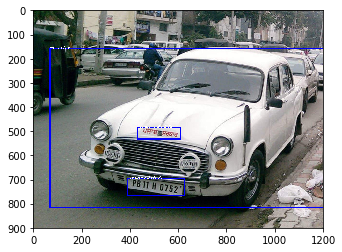

Inference time: -1179.24 ms


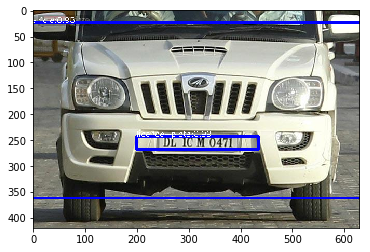

Inference time: -1244.91 ms


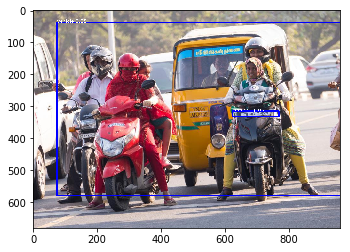

Inference time: -1259.46 ms


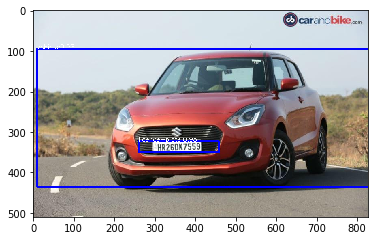

Inference time: -1273.08 ms


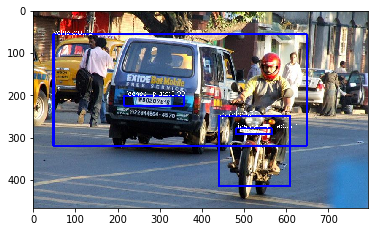

Inference time: -1191.34 ms


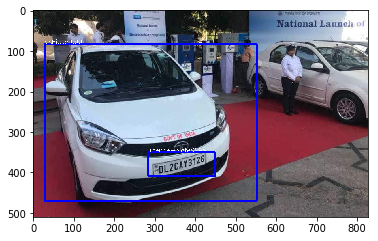

Inference time: -1256.67 ms


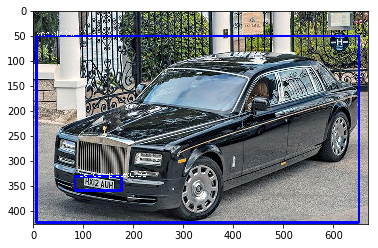

Inference time: -1182.05 ms


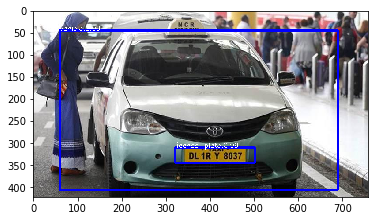

Inference time: -1268.39 ms


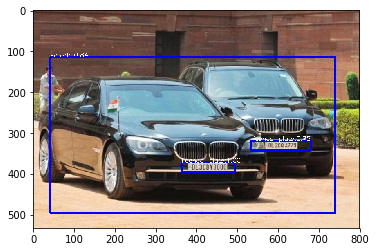

Inference time: -1253.73 ms


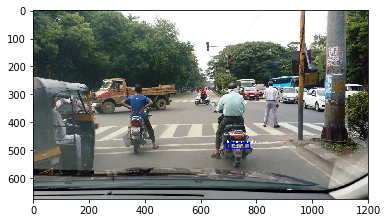

Inference time: -1189.96 ms


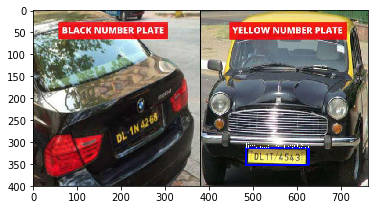

Inference time: -1253.09 ms


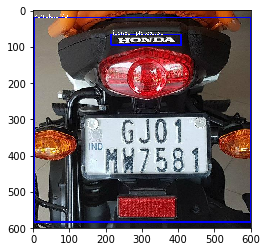

Inference time: -1250.75 ms


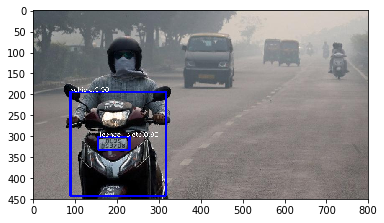

Inference time: -1263.65 ms


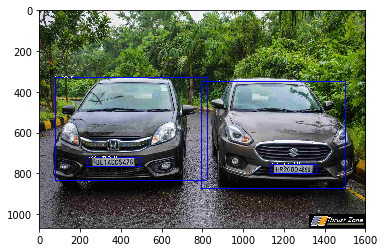

Inference time: -1162.03 ms


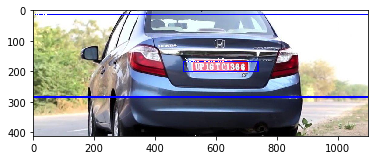

Inference time: -1252.55 ms


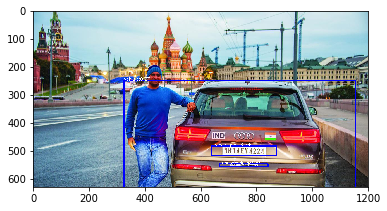

Inference time: -1256.19 ms


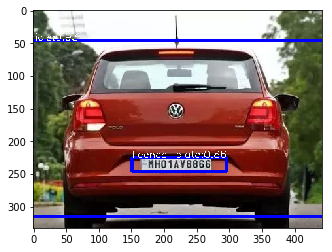

Inference time: -1250.94 ms


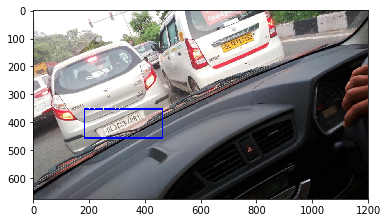

Inference time: -1254.90 ms


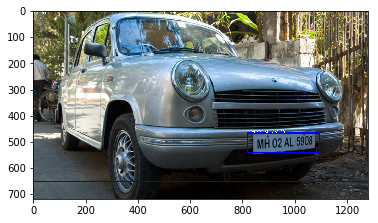

Inference time: -1249.28 ms


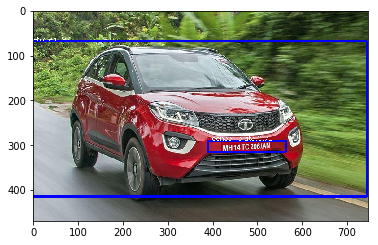

Inference time: -1249.76 ms


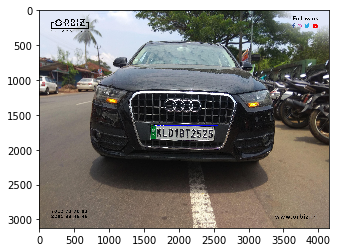

Inference time: -1257.76 ms


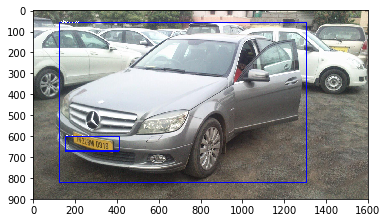

Inference time: -1255.01 ms


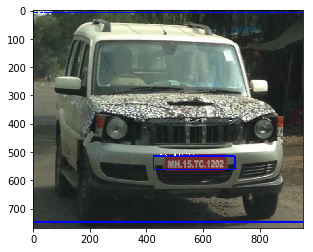

In [29]:
testdir= '/content/vehicle-and-lp-dataset/test'
test_files = os.listdir(testdir)
for name in test_files:
  path = join(testdir, name)
  img = cv2.imread(path)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  blob = cv2.dnn.blobFromImage(img, 1/255, (608, 608), [0,0,0], 1, crop=False) # Create a 4D blob from a frame.
  net.setInput(blob) # Sets the input to the network
  outs = net.forward(getOutputsNames(net)) # Runs the forward pass to get output of the output layers
  postprocess(img, outs) # Remove the bounding boxes with low confidence
 
  plt.imshow(img)
  plt.show()

## References

https://pjreddie.com/darknet/yolo/

https://www.learnopencv.com/deep-learning-based-object-detection-using-yolov3-with-opencv-python-c/